### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import egg.core as core
from egg.core import Callback, Interaction, PrintValidationEvents
from torchvision import models, datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
from IPython.display import clear_output
import time
import json

import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Preparing the Data
Loading the Dataset

In [2]:
class EGG_Dataset(Dataset):
    '''
    A dataset that is read in from a txt file and is compatible with the EGG framework and PyTorch's DataLoader.
    
    Attributes:
        frame -- The dataset
        
    Methods:
        __init__(game_data_path, test_or_val) -- Constructor, initializes a dataset object
        get_n_features() -- Returns the dimension of an image embedding
        __len__() -- Returns the lenght of the dataset
        __getitem__(idx) -- Returns an element of the dataset by the given index idx
    '''
    def __init__(self, game_data_path, test=False):
        '''
        Constructor, initializes an EGG_Dataset object, i.e. a dataset that is compatible with both EGG
        and PyTorch's DataLoader.
        
        Parameter:
            game_data_path -- The path to the game data (train, val, or test) for which a dataset is to be produced
            test -- Boolean that indicates whether or not the dataset will be used for testing
        '''
        self.frame = []
        with open(game_data_path, 'r') as game_data:
            for i,line in enumerate(game_data):
                # splits row into list with an element for each embedding and the target idx (at last position)
                raw_info = line.split(",")
                # stores the embeddings in nested list index_vectors and casts values to int
                # , e.g. [[feat1, feat2, feat3], [feat1, feat2, feat3]]
                embeddings = list([list(map(float, x.split())) for x in raw_info[:3]])
                # index of the target embedding
                target_idx = torch.tensor(int(raw_info[-1]))
                # the target embedding, which is the sender input
                target_embedding = torch.FloatTensor(embeddings[target_idx])
                # constructing the receiver input, i.e. storing target and distractor embeddings in one tensor
                target_and_distractors = []
                for embedding in embeddings:
                    target_and_distractors = np.concatenate((target_and_distractors, embedding))
                target_and_distractors = torch.FloatTensor(target_and_distractors).view(len(embeddings), -1)
                # for training and validation data: storing sender input, target_index, and receiver input in data frame
                if not test:
                    self.frame.append((target_embedding, target_idx, target_and_distractors))
                # for test data additionally store the ImageNet class of the target image
                elif test:
                    target_class = int(raw_info[-2])
                    self.frame.append((target_embedding, target_idx, target_and_distractors, target_class))
        
    def get_n_features(self):
        'Returns the dimension of the image embeddings'
        return self.frame[0][0].size(0)

    def __len__(self):
        'Returns the length of the dataset'
        return len(self.frame)

    def __getitem__(self, idx):
        'Returns an element of the dataset by index'
        return self.frame[idx]

In [3]:
#train_and_val_dataset = EGG_Dataset('./data/CIFAR100_embeddings/Train.txt')
#[train_dataset, val_dataset] = torch.utils.data.random_split(train_and_val_dataset, [0.9, 0.1])
train_dataset = EGG_Dataset('./data/Imagenet_embeddings/train.txt')

In [4]:
train_dataset.__len__()

150000

In [5]:
val_dataset = EGG_Dataset('./data/Imagenet_embeddings/val.txt')
val_dataset.__len__()

30000

In [6]:
#test_dataset = EGG_Dataset('./data/CIFAR100_embeddings/Validation.txt', val=True)
test_dataset = EGG_Dataset('./data/Imagenet_embeddings/test.txt', test=True)
test_dataset.__len__()

100000

In [7]:
for entry in test_dataset:
    print(entry)
    break

(tensor([9.2750e-01, 3.4042e-01, 4.0488e-01, 1.1748e+00, 6.0197e-01, 1.0601e+00,
        9.6262e-01, 2.6407e+00, 3.3787e+00, 7.8537e-01, 4.3155e-02, 1.3846e+00,
        1.8453e-01, 4.6082e-01, 1.6010e+00, 1.2607e+00, 1.0856e-01, 1.2905e+00,
        5.4095e-01, 3.4053e-01, 4.6451e-01, 1.9884e+00, 4.1528e-01, 5.8136e-01,
        1.8169e-01, 6.6351e-01, 3.2706e-01, 1.5425e+00, 1.2707e+00, 2.9524e-01,
        4.5828e-01, 6.1853e-01, 6.9168e-01, 1.2879e+00, 2.7106e-01, 9.2314e-02,
        1.3245e-01, 9.7951e-01, 8.2267e-01, 4.9564e-01, 1.4362e-01, 1.2296e+00,
        6.0714e-01, 2.1625e+00, 7.8000e-01, 7.2583e-01, 3.6503e-01, 5.6950e-01,
        1.4064e+00, 9.7976e-01, 1.2731e+00, 5.0920e-01, 6.9816e-01, 5.0858e-01,
        1.3666e+00, 1.2761e+00, 1.9342e+00, 8.8642e-01, 4.7492e-01, 6.6617e-01,
        3.0585e-01, 3.8304e-01, 1.3592e+00, 9.5307e-01, 4.8516e-01, 8.2257e-01,
        9.1903e-01, 3.7771e-01, 4.5785e-01, 9.0376e-01, 2.8151e-01, 9.5065e-01,
        1.9340e-01, 5.7723e-01, 5.5072e

### Implementing the Sender

In [8]:
class Sender(nn.Module):
    '''
    The core of any sender agent. It takes the embedding of the target image as input and produces an initial
    hidden state for the message producing GRU (that will be initialized via an EGG-Wrapper below).
    
    Attributes:
        fc1 -- The only layer of the sender's core
    
    Methods:
        __init__(n_hidden, n_features) -- Constructor, initializes the sender's core
        forward(x, _aux_input) -- Performs a forward pass through the sender's core 
    '''
    def __init__(self, n_hidden, n_features):
        '''
        Constructor, initializes the sender's core.
        
        Parameter:
            n_features -- The input size, i.e. the number of elements in an image embedding
            n_hidden -- The output size, i.e. the size of the hidden states in the message producing GRU
            
        Output:
            None
        '''
        super(Sender, self).__init__()
        self.fc1 = nn.Linear(n_features, n_hidden)

    def forward(self, x, _aux_input):
        '''Performs a forward pass through the sender's core, i.e. maps the target img embedding x to 
        the initial hidden state of the GRU and returns this mapping'''
        return self.fc1(x)
        return self.fc1(x).tanh()
        #return self.fc1(x).LeakyReLu
        # here, it might make sense to add a non-linearity, such as tanh

### Implementing the Receiver

In [9]:
class Receiver(nn.Module):
    '''
    The core of any receiver agent. It takes two inputs: a message embedding from its wrapper GRU and the image
    embeddings of the target and distractors. Target and distractor embeddings are mapped to the same dimension
    as the message embedding and then computes the dot product between the message embedding and each of the mapped
    image embeddings. The resulting list of dot products is interpreted as a non-normalized probability distribution
    over possible target positions, i.e. the highest dot product was computed using the mapped embedding of the target image.
    
    Attributes:
        fc1 -- The only layer of the receiver's core
        
    Methods:
        __init__(n_features, n_hidden) -- Constructor, initializes a receiver's core
        forward(x, _input, _aux_input) -- Performs a forward pass through the receiver's core
    '''
    def __init__(self, n_features, n_hidden):
        '''
        Constructor, initalizes the sender's core.
        
        Parameter:
            n_features -- The input sizes of the target and distractor embeddings
            n_hidden -- The size of the wrapper-GRU's hidden state
            
        Output:
            None
        '''
        super(Receiver, self).__init__()
        self.fc1 = nn.Linear(n_features, n_hidden)

    def forward(self, x, _input, _aux_input):
        '''
        Performs a forward pass through the receiver's core, i.e. maps all embeddings of target and distractor
        images to the dimension of the wrapper-GRU's message embedding and then computes and returns the dot
        products between all target/distractor mappings and the message embedding.
        
        Parameter:
            x -- The message embedding produced by the wrapper-GRU
            _input -- The embeddings of target and distractor images
        
        Output:
            dots -- A list of dot products between mapped image embeddings and the message embedding, the element
                    with the highest dot product acts as the receiver's prediction of the target position
        '''
        # the rationale for the non-linearity here is that the RNN output (x) will also be the outcome of a non-linearity
        embedded_input = self.fc1(_input).tanh()
        dots = torch.matmul(embedded_input, torch.unsqueeze(x, dim=-1))
        #return dots.squeeze()
        return F.softmax(dots.squeeze(), dim = 1)

### Set Parameters

In [10]:
# game parameter
vocab_size = 10
max_len = 5

# agent parameter
sender_hidden = 10
receiver_hidden = 35
sender_embedding = 5
receiver_embedding = 5
sender_cell = 'gru'
receiver_cell = 'gru'
n_features = test_dataset.get_n_features()

# training parameter, defined on egg level for optimizer call in game initialization
patience = 50
opts = core.init(params=['--lr=1e-4',
                         '--batch_size=128',
                         '--optimizer=adam'])

# setting a PyTorch seed
seed = 5
torch.manual_seed(seed)

### Load Datasets

In [11]:
train_loader = DataLoader(train_dataset, batch_size=opts.batch_size, shuffle=True, num_workers=0, drop_last = True, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=opts.batch_size, shuffle=True, num_workers=0, drop_last = True, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=opts.batch_size, shuffle=True, num_workers=0, drop_last = True, pin_memory=False)

### Define Loss Function

In [12]:
def loss(_sender_input, _message, _receiver_input, receiver_output, labels, _aux_input):
    '''
    The loss function used for optimizing the game agents. EGG requires the loss function to have all these
    parameters even if they are not used for the loss computation.
    
    Parameter (all parameters have on value for each element in the batch):
        _sender_input -- The input to the sender (an image embedding), not used for my loss computation
        _message -- The message produced by the sender, not used for my loss computation
        _receiver_input -- The input to the receiver (target + distractors), not used for my loss computation
        receiver_output -- The output of the receiver
        labels -- The indexes of the target images
        
    Output:
        loss, {'acc': acc}
            loss -- The cross entropy between the receiver output and the labels
            acc -- The success rates (0 or 1) of all samples in the batch
    '''
    global batch_accs, batch_losses, validate
    # in the discriminative case, accuracy is computed by comparing the index with highest score in Receiver output (a distribution of unnormalized
    # probabilities over target poisitions) and the corresponding label read from input, indicating the ground-truth position of the target
    acc = (receiver_output.argmax(dim=1).to(device) == labels.to(device)).detach().float()
    # similarly, the loss computes cross-entropy between the Receiver-produced target-position probability distribution and the labels
    loss = F.cross_entropy(receiver_output.to(device), labels.to(device), reduction="none")
    batch_accs.append(torch.mean(acc).item())
    batch_losses.append(torch.mean(loss).item())
        
    
    return loss, {"acc": acc}

### Set Up the Game

In [13]:
sender = Sender(n_hidden=sender_hidden, n_features=n_features).to(device)
sender = core.RnnSenderReinforce(
                            sender,
                            vocab_size=vocab_size,
                            embed_dim=sender_embedding,
                            hidden_size=sender_hidden,
                            cell=sender_cell,
                            max_len=max_len,
                            ).to(device)
receiver = Receiver(n_features=n_features, n_hidden=receiver_hidden).to(device)
receiver = core.RnnReceiverDeterministic(
                            receiver,
                            vocab_size=vocab_size,
                            embed_dim=receiver_embedding,
                            hidden_size=receiver_hidden,
                            cell=receiver_cell,
                            ).to(device)

In [14]:
game = core.SenderReceiverRnnReinforce(
                            sender,
                            receiver,
                            loss,
                            sender_entropy_coeff=0,
                            receiver_entropy_coeff=0,
                            ).to(device)
current_callbacks = []
current_optimizer = core.build_optimizer(game.parameters())

In [15]:
trainer = core.Trainer(
            game=game,
            optimizer=current_optimizer,
            train_data=train_loader,
            callbacks=current_callbacks+ [core.ConsoleLogger(print_train_loss=True, as_json=True)],
            )

In [16]:
'''
def train(egg_trainer):
    global batch_accs, batch_losses
    batch_accs = []
    batch_losses = []
    egg_trainer.train(n_epochs = 1)

    return (np.array(batch_accs).mean(), np.array(batch_losses).mean())
'''
def check_performance(dataset):
    '''
    Checks the communities performance on the provided dataset. To do so, a pair is sampled from the community
    for each batch in the dataset. That pair's loss and accuracy are computed and stored.
    
    Parameter:
        dataset -- The dataset for which the communities performance is to be tested.
        
    Output:
        (accuracy, loss)
            accuracy -- The average accuracy achieved by the sampled pairs on the dataset's batches.
            loss -- The average loss achieved by the sampled pairs on the dataset's batches.
    '''
    global batch_accs, batch_losses
    batch_accs = []
    batch_losses = []
    
    
    for batch in dataset:
        try:
            (sender_inputs, target_idxs, receiver_inputs, target_classes) = batch
        except ValueError:
            (sender_inputs, target_idxs, receiver_inputs) = batch
            
        with torch.no_grad():

            messages, __sen_logprobs, __sen_entropies = sender(sender_inputs.to(device))
            rec_outputs, __rec_logrobs, __rec_entropies = receiver(messages.to(device), receiver_inputs.to(device), aux_input=None)
            
            loss_fn_output = loss(sender_inputs, messages, receiver_inputs, rec_outputs, target_idxs, None)
        
    return (np.array(batch_accs, dtype=float).mean(), np.array(batch_losses, dtype=float).mean())

def visualize(train_accs, train_losses, val_accs, val_losses, results_dir):
    '''
    Plots the communities performance on the train and on the validation dataset.
    
    Parameter:
        train_accs -- The accuracies on the training data achieved by the community for all completed epochs
        train_losses -- The losses on the training data achieved by the community for all completed epochs
        val_accs -- The accuracies on the validation data achieved by the community for all completed epochs
        val_losses -- The losses on the validation data achieved by the community for all completed epochs
        
    Output:
        None
        Prints the plots in the console
    '''
    total_nr_epochs = len(train_accs)
    #clear_output(wait = True)
    plt.figure(figsize = (15,7))
    line1, = plt.plot(range(0,len(train_losses)),train_losses)
    line2, = plt.plot(range(0,len(val_losses)),val_losses)
    plt.xlabel("Epoch")
    plt.xlim(0,total_nr_epochs)
    plt.ylabel("Loss")
    plt.legend((line1,line2),("training","validation"))
    plt.grid(True)
    plt.savefig(results_dir+'train_and_val_losses.png')
    plt.show()

    plt.figure(figsize = (15,7))
    line1, = plt.plot(range(0,len(train_accs)),train_accs)
    line2, = plt.plot(range(0,len(val_accs)),val_accs)
    plt.xlabel("Epoch")
    plt.xlim(0,total_nr_epochs)
    plt.ylabel("Accuracy")
    plt.ylim(0,1.05)
    plt.yticks(np.arange(0, 1.05, 0.05))
    plt.legend((line1,line2),("training","validation"))
    plt.grid(True)
    plt.savefig(results_dir+'train_and_val_accs.png')
    plt.show()
    
def visualize_training(train_accs, train_losses):
    '''
    Plots the communities performance on the train and on the validation dataset.
    
    Parameter:
        train_accs -- The accuracies on the training data achieved by the community for all completed epochs
        train_losses -- The losses on the training data achieved by the community for all completed epochs
        val_accs -- The accuracies on the validation data achieved by the community for all completed epochs
        val_losses -- The losses on the validation data achieved by the community for all completed epochs
        
    Output:
        None
        Prints the plots in the console
    '''
    total_nr_epochs=len(train_accs)
    
    plt.figure(figsize = (15,7))
    line1, = plt.plot(range(0,len(train_losses)),train_losses)
    plt.xlabel("Epoch")
    plt.xlim(0,total_nr_epochs)
    plt.ylabel("Loss")
    plt.title("Loss Across Epochs")
    plt.grid(True)
    plt.show()

    plt.figure(figsize = (15,7))
    line1, = plt.plot(range(0,len(train_accs)),train_accs)
    plt.xlabel("Epoch")
    plt.xlim(0,total_nr_epochs)
    plt.ylabel("Accuracy")
    plt.title("Accuracy Across Epochs")
    plt.ylim(0,1.05)
    plt.yticks(np.arange(0, 1.05, 0.05))
    plt.grid(True)
    plt.show()

In [17]:
total_time_start = time.time()
global batch_accs, batch_losses

n_epochs = 200
epoch_train_accs = []
epoch_train_losses = []
epoch_val_accs = []
epoch_val_losses = []
start_train_accs, start_train_losses = check_performance(train_loader)
start_val_accs, start_val_losses = check_performance(val_loader)
epoch_train_accs.append(start_train_accs)
epoch_train_losses.append(start_train_losses)
epoch_val_accs.append(start_val_accs)
epoch_val_losses.append(start_val_losses)
for i in range(n_epochs):
    batch_accs = []
    batch_losses = []
    print('Epoch: ', i+1)
    trainer.train(n_epochs = 1)
    epoch_train_accs.append(np.mean(np.array(batch_accs)))
    epoch_train_losses.append(np.mean(np.array(batch_losses)))
    val_accs, val_losses = check_performance(val_loader)
    epoch_val_accs.append(val_accs)
    epoch_val_losses.append(val_losses)
    
total_time_end = time.time()
total_time = total_time_end - total_time_start

Epoch:  1
{"loss": 1.1726497411727905, "acc": 0.43167564272880554, "sender_entropy": 1.4465157985687256, "receiver_entropy": 0.0, "length": 5.425430774688721, "mode": "train", "epoch": 1}
Epoch:  2
{"loss": 1.2115973234176636, "acc": 0.7075549960136414, "sender_entropy": 0.5803739428520203, "receiver_entropy": 0.0, "length": 5.939688205718994, "mode": "train", "epoch": 1}
Epoch:  3
{"loss": 0.9972926378250122, "acc": 0.7891225218772888, "sender_entropy": 0.37629076838493347, "receiver_entropy": 0.0, "length": 5.977196216583252, "mode": "train", "epoch": 1}
Epoch:  4
{"loss": 0.8831438422203064, "acc": 0.8190115094184875, "sender_entropy": 0.2855052649974823, "receiver_entropy": 0.0, "length": 5.986923694610596, "mode": "train", "epoch": 1}
Epoch:  5
{"loss": 0.8226012587547302, "acc": 0.8407277464866638, "sender_entropy": 0.22895853221416473, "receiver_entropy": 0.0, "length": 5.993588447570801, "mode": "train", "epoch": 1}
Epoch:  6
{"loss": 0.7909904718399048, "acc": 0.85494500398635

Epoch:  45
{"loss": 0.6434193253517151, "acc": 0.9430574774742126, "sender_entropy": 0.08268725872039795, "receiver_entropy": 0.0, "length": 5.999726295471191, "mode": "train", "epoch": 1}
Epoch:  46
{"loss": 0.6427053213119507, "acc": 0.9421501159667969, "sender_entropy": 0.08000891655683517, "receiver_entropy": 0.0, "length": 5.999819755554199, "mode": "train", "epoch": 1}
Epoch:  47
{"loss": 0.6420204043388367, "acc": 0.9446386694908142, "sender_entropy": 0.08116114139556885, "receiver_entropy": 0.0, "length": 5.999739646911621, "mode": "train", "epoch": 1}
Epoch:  48
{"loss": 0.6420241594314575, "acc": 0.9428372979164124, "sender_entropy": 0.07606978714466095, "receiver_entropy": 0.0, "length": 5.999786376953125, "mode": "train", "epoch": 1}
Epoch:  49
{"loss": 0.6403425931930542, "acc": 0.9446786642074585, "sender_entropy": 0.07716719806194305, "receiver_entropy": 0.0, "length": 5.999692916870117, "mode": "train", "epoch": 1}
Epoch:  50
{"loss": 0.6400666236877441, "acc": 0.944358

Epoch:  89
{"loss": 0.6246741414070129, "acc": 0.9544059634208679, "sender_entropy": 0.06047134846448898, "receiver_entropy": 0.0, "length": 5.999859809875488, "mode": "train", "epoch": 1}
Epoch:  90
{"loss": 0.6248392462730408, "acc": 0.9535920023918152, "sender_entropy": 0.05740870162844658, "receiver_entropy": 0.0, "length": 5.999813079833984, "mode": "train", "epoch": 1}
Epoch:  91
{"loss": 0.6232469081878662, "acc": 0.9551464915275574, "sender_entropy": 0.05878468230366707, "receiver_entropy": 0.0, "length": 5.999732971191406, "mode": "train", "epoch": 1}
Epoch:  92
{"loss": 0.6240431070327759, "acc": 0.9551131725311279, "sender_entropy": 0.05897584185004234, "receiver_entropy": 0.0, "length": 5.999819755554199, "mode": "train", "epoch": 1}
Epoch:  93
{"loss": 0.6228244304656982, "acc": 0.9555801749229431, "sender_entropy": 0.05957375839352608, "receiver_entropy": 0.0, "length": 5.999799728393555, "mode": "train", "epoch": 1}
Epoch:  94
{"loss": 0.6231933236122131, "acc": 0.955740

Epoch:  133
{"loss": 0.6153836250305176, "acc": 0.9616246819496155, "sender_entropy": 0.050320062786340714, "receiver_entropy": 0.0, "length": 5.999379634857178, "mode": "train", "epoch": 1}
Epoch:  134
{"loss": 0.6158254742622375, "acc": 0.9601569175720215, "sender_entropy": 0.05034669116139412, "receiver_entropy": 0.0, "length": 5.999339580535889, "mode": "train", "epoch": 1}
Epoch:  135
{"loss": 0.6143789887428284, "acc": 0.961738109588623, "sender_entropy": 0.04931036755442619, "receiver_entropy": 0.0, "length": 5.9994797706604, "mode": "train", "epoch": 1}
Epoch:  136
{"loss": 0.6149149537086487, "acc": 0.9616313576698303, "sender_entropy": 0.04915342107415199, "receiver_entropy": 0.0, "length": 5.9994797706604, "mode": "train", "epoch": 1}
Epoch:  137
{"loss": 0.6141211986541748, "acc": 0.9621517658233643, "sender_entropy": 0.04986334964632988, "receiver_entropy": 0.0, "length": 5.99949312210083, "mode": "train", "epoch": 1}
Epoch:  138
{"loss": 0.6139621734619141, "acc": 0.96198

Epoch:  177
{"loss": 0.6104245781898499, "acc": 0.9662681221961975, "sender_entropy": 0.05079655721783638, "receiver_entropy": 0.0, "length": 5.999639511108398, "mode": "train", "epoch": 1}
Epoch:  178
{"loss": 0.6101900935173035, "acc": 0.9661080241203308, "sender_entropy": 0.050065986812114716, "receiver_entropy": 0.0, "length": 5.999706268310547, "mode": "train", "epoch": 1}
Epoch:  179
{"loss": 0.6098486185073853, "acc": 0.9660279750823975, "sender_entropy": 0.051220763474702835, "receiver_entropy": 0.0, "length": 5.999606609344482, "mode": "train", "epoch": 1}
Epoch:  180
{"loss": 0.6104768514633179, "acc": 0.9658411741256714, "sender_entropy": 0.05057262256741524, "receiver_entropy": 0.0, "length": 5.9997663497924805, "mode": "train", "epoch": 1}
Epoch:  181
{"loss": 0.6104191541671753, "acc": 0.9646602869033813, "sender_entropy": 0.05056199058890343, "receiver_entropy": 0.0, "length": 5.999759674072266, "mode": "train", "epoch": 1}
Epoch:  182
{"loss": 0.6094464659690857, "acc":

[0.3327751387702818, 0.43167565115286083, 0.707554974380871, 0.7891225448334757, 0.8190115286080273, 0.8407277433817251, 0.854945025619129, 0.8675010674637063, 0.8733187446626814, 0.8814314688300597, 0.8878495943637916, 0.8925264197267293, 0.8967629163108455, 0.9027073548249359, 0.905015745089667, 0.9082781810418445, 0.9097526152860803, 0.9127281703672075, 0.9152300384286934, 0.9171714880444065, 0.9210877455166524, 0.9224821199829206, 0.9241700469684031, 0.9251040777113578, 0.9267252882152007, 0.9290336784799317, 0.9281530209222887, 0.9309884713919727, 0.9312486656703672, 0.932349487617421, 0.9341508326216909, 0.935365072587532, 0.9356853116994022, 0.936072267292912, 0.9367260888129804, 0.9386141652433817, 0.93891438941076, 0.9358454312553374, 0.938567463706234, 0.9394748078565329, 0.9397149871904356, 0.9420967655849701, 0.9424236763450042, 0.9398417485055508, 0.9427105572160547, 0.9430574829205807, 0.9421501387702819, 0.9446386635354398, 0.9428373185311699, 0.9446786934244236, 0.94435

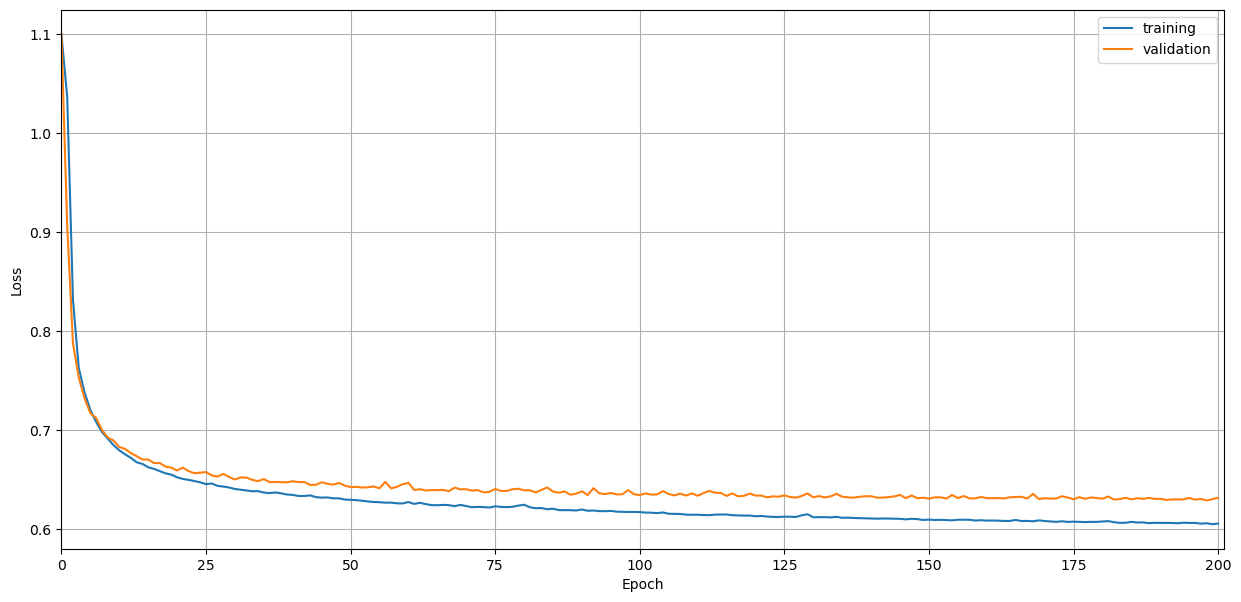

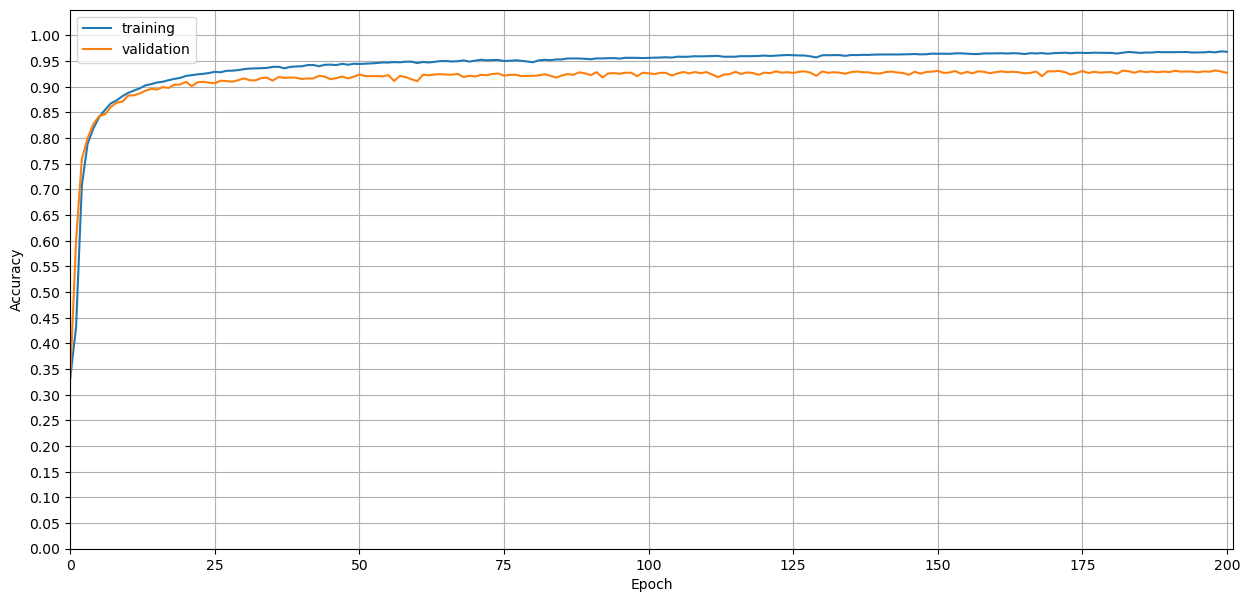

In [18]:
results_dir = './Results/Text/Seed_'+str(seed)+'/'
print(epoch_train_accs)
print(epoch_train_losses)
print(epoch_val_accs)
print(epoch_val_losses)
visualize(epoch_train_accs, epoch_train_losses, epoch_val_accs, epoch_val_losses, results_dir)

In [19]:
test_acc, test_loss = check_performance(test_loader)
print('Accuracy on the test dataset:', test_acc)
print('Loss on the test dataset:', test_loss)

Accuracy on the test dataset: 0.9255961907810499
Loss on the test dataset: 0.632178551866822


### Storing accuracies and losses during training, test accuracy and loss and plots

In [20]:
# saving the train accs of all epochs
with open(results_dir+'train_accs.txt', 'w') as f:
    json.dump(epoch_train_accs, f)

# saving the train losses of all epochs
with open(results_dir+'train_losses.txt', 'w') as f:
    json.dump(epoch_train_losses, f)

# saving the validation accuracies of all epochs
with open(results_dir+'val_accs.txt', 'w') as f:
    json.dump(epoch_val_accs, f)

# saving the validation losses of all epochs
with open(results_dir+'val_losses.txt', 'w') as f:
    json.dump(epoch_val_losses, f)
    
# saving the test accuracy
with open(results_dir+'test_acc.txt', 'w') as f:
    json.dump(test_acc, f)

# saving the test loss
with open(results_dir+'test_loss.txt', 'w') as f:
    json.dump(test_loss, f)

### Producing the evaluation data (The messages produced for each sample in the test dataset)

In [21]:
with open(results_dir+'evaluation_data.csv', 'w') as file:
    writer = csv.writer(file)
    header = ['id', 'sender_input', 'target_class', 'accuracy', 'message']
    writer.writerow(header)
    row_nr = 0
    
    for (sender_inputs, target_idxs, receiver_inputs, target_classes) in test_loader:
        current_batch_size = len(target_idxs)
        # messages contains one entry for each sender and each of these entries is a batch of messages
        messages, _batch_sen_logprobs, _batch_sen_entropies = sender(sender_inputs.to(device))
        
        # contains one list for each batch of messages. These lists contain one list from each receiver
        # corresponding to the receiver's outputs given that message batch. In other words, the first
        # element contains the receiver outputs of all pairs involving sender1, the second one of all pairs
        # involving sender2 and so on.
        rec_outputs, _batch_rec_logrobs, _batch_rec_entropies = receiver(messages, receiver_inputs.to(device))
        
        # one row for each element in the batch
        for i in range(current_batch_size):
            row_nr += 1
            sender_input = str(sender_inputs[i].tolist()).replace('[', '').replace(']', '')
            target_class = target_classes[i].item()
            row = [row_nr, sender_input, target_class]
            
            sample_target_idx = target_idxs[i]
            rec_output = rec_outputs[i]
            sample_acc = int(rec_output.argmax(dim=0)==sample_target_idx)
            row.append(sample_acc)
            message = str(messages[i].tolist()).replace('[', '').replace(']', '')
            row.append(message)

            writer.writerow(row)